# Spoofing Detection: Kalman Filter Approach

This notebook explains the Kalman Filter-based spoofing detection method.

## Intuition

A receiver measures RSSI (signal strength) from a transmitter claiming to be at position $\mathbf{p}_{claimed}$. If we know the receiver's position $\mathbf{p}_{rx}$, we can:

1. Compute the claimed distance: $d_{claimed} = |\mathbf{p}_{claimed} - \mathbf{p}_{rx}|$
2. Use a path loss model to predict what RSSI we *should* see at that distance
3. Compare predicted vs actual RSSI

For an **honest transmitter**, the claimed position is true, so RSSI matches prediction.

For a **spoofer**, the claimed position is fake. The actual RSSI depends on the *real* distance, which differs from claimed distance. This creates a mismatch.

The Kalman Filter tracks this mismatch over time, building confidence about whether the transmitter is honest or spoofing.

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.set_printoptions(precision=4, suppress=True)

## Step 1: Path Loss Model

RSSI decreases with distance according to the log-distance path loss model:

$$RSSI = P_{tx} - 10 \cdot n \cdot \log_{10}(d)$$

Where:
- $P_{tx}$ = transmit power (dBm)
- $n$ = path loss exponent (2.0 for free space, higher with obstacles)
- $d$ = distance (meters)

Rearranging to estimate TX power from RSSI and distance:

$$\hat{P}_{tx} = RSSI + 10 \cdot n \cdot \log_{10}(d)$$

In [60]:
def estimate_tx_power(rssi, distance, path_loss_exp=2.0):
    """Estimate TX power from RSSI and distance."""
    return rssi + 10 * path_loss_exp * np.log10(distance)

def expected_rssi(tx_power, distance, path_loss_exp=2.0):
    """Expected RSSI given TX power and distance."""
    return tx_power - 10 * path_loss_exp * np.log10(distance)

# Example: honest transmitter
true_tx_power = 15  # dBm
true_distance = 100  # meters
true_rssi = expected_rssi(true_tx_power, true_distance)

print(f"Honest transmitter at {true_distance}m with TX power {true_tx_power} dBm")
print(f"Expected RSSI: {true_rssi:.2f} dBm")
print(f"Estimated TX power from RSSI: {estimate_tx_power(true_rssi, true_distance):.2f} dBm")

Honest transmitter at 100m with TX power 15 dBm
Expected RSSI: -25.00 dBm
Estimated TX power from RSSI: 15.00 dBm


In [61]:
# Example: spoofer
# Spoofer is actually at 50m but claims to be at 200m
actual_distance = 50
claimed_distance = 200
spoofer_tx_power = 15

# RSSI is based on ACTUAL distance
actual_rssi = expected_rssi(spoofer_tx_power, actual_distance)

# But receiver uses CLAIMED distance to estimate TX power
estimated_tx = estimate_tx_power(actual_rssi, claimed_distance)

print(f"Spoofer: actual distance={actual_distance}m, claims {claimed_distance}m")
print(f"Actual RSSI: {actual_rssi:.2f} dBm")
print(f"Estimated TX power (using claimed distance): {estimated_tx:.2f} dBm")
print(f"True TX power: {spoofer_tx_power} dBm")
print(f"\nMismatch: {estimated_tx - spoofer_tx_power:.2f} dB")
print("The estimated TX power is way too high - this is suspicious!")

Spoofer: actual distance=50m, claims 200m
Actual RSSI: -18.98 dBm
Estimated TX power (using claimed distance): 27.04 dBm
True TX power: 15 dBm

Mismatch: 12.04 dB
The estimated TX power is way too high - this is suspicious!


## Step 2: The Kalman Filter

Instead of detecting on a single measurement (which is noisy), we use a Kalman Filter to:
1. Track the estimated TX power over time
2. Build confidence in our estimate
3. Detect anomalies via the **Normalized Innovation Squared (NIS)**

### State Model

- **State**: $x = P_{tx}$ (estimated transmit power)
- **Measurement**: $z = RSSI + 10n\log_{10}(d_{claimed})$ (TX power estimate from single measurement)

### KF Equations

**Prediction** (TX power is constant):
$$\hat{x}^- = \hat{x}$$
$$P^- = P + Q$$

**Update**:
$$K = P^- / (P^- + R)$$
$$\nu = z - \hat{x}^- \quad \text{(innovation)}$$
$$\hat{x} = \hat{x}^- + K \nu$$
$$P = (1-K) P^-$$

**Normalized Innovation Squared (NIS)**:
$$\text{NIS} = \frac{\nu^2}{P^- + R}$$

For a correctly-specified model, NIS follows a $\chi^2(1)$ distribution. Large NIS values indicate model mismatch → spoofing!

In [62]:
class TxPowerKalmanFilter:
    """Kalman Filter for tracking TX power and detecting anomalies."""
    
    def __init__(self, process_noise=0.1, measurement_noise=9.0, initial_estimate=13.0, initial_covariance=100.0):
        self.Q = process_noise      # Process noise variance
        self.R = measurement_noise  # Measurement noise variance (RSSI noise ~3dB std → 9 var)
        self.x = initial_estimate   # State estimate
        self.P = initial_covariance # State covariance
        
    def update(self, measurement):
        """Process a measurement and return NIS."""
        # Prediction (TX power is constant, so x_pred = x)
        x_pred = self.x
        P_pred = self.P + self.Q
        
        # Innovation
        innovation = measurement - x_pred
        S = P_pred + self.R  # Innovation covariance
        
        # NIS (our detection statistic)
        nis = (innovation ** 2) / S
        
        # Kalman gain and update
        K = P_pred / S
        self.x = x_pred + K * innovation
        self.P = (1 - K) * P_pred
        
        return nis, innovation, self.x, self.P

# Demonstrate with honest transmitter
kf = TxPowerKalmanFilter()
true_tx = 15.0
distance = 100.0

print("Honest transmitter (TX=15dBm, distance=100m):")
print(f"{'Meas#':>5} {'RSSI':>8} {'z (est TX)':>10} {'NIS':>8} {'x_hat':>8} {'P':>8}")
print("-" * 55)

np.random.seed(42)
for i in range(10):
    # Simulate noisy RSSI measurement
    rssi = expected_rssi(true_tx, distance) + np.random.randn() * 3  # 3dB noise
    z = estimate_tx_power(rssi, distance)  # Measurement
    
    nis, innov, x_hat, P = kf.update(z)
    print(f"{i+1:>5} {rssi:>8.2f} {z:>10.2f} {nis:>8.3f} {x_hat:>8.2f} {P:>8.2f}")

Honest transmitter (TX=15dBm, distance=100m):
Meas#     RSSI z (est TX)      NIS    x_hat        P
-------------------------------------------------------
    1   -23.51      16.49    0.112    16.20     8.26
    2   -25.41      14.59    0.151    15.42     4.33
    3   -23.06      16.94    0.172    15.93     2.97
    4   -20.43      19.57    1.100    16.85     2.29
    5   -25.70      14.30    0.573    16.32     1.89
    6   -25.70      14.30    0.371    15.95     1.63
    7   -20.26      19.74    1.337    16.56     1.45
    8   -22.70      17.30    0.052    16.67     1.32
    9   -26.41      13.59    0.909    16.25     1.23
   10   -23.37      16.63    0.014    16.30     1.16


In [63]:
# Now demonstrate with a spoofer
kf = TxPowerKalmanFilter()
true_tx = 15.0
actual_distance = 50.0
claimed_distance = 200.0

print("Spoofer (TX=15dBm, actual=50m, claims 200m):")
print(f"{'Meas#':>5} {'RSSI':>8} {'z (est TX)':>10} {'NIS':>8} {'x_hat':>8} {'P':>8}")
print("-" * 55)

np.random.seed(42)
for i in range(10):
    # RSSI based on ACTUAL distance
    rssi = expected_rssi(true_tx, actual_distance) + np.random.randn() * 3
    # But we use CLAIMED distance to estimate TX power
    z = estimate_tx_power(rssi, claimed_distance)
    
    nis, innov, x_hat, P = kf.update(z)
    print(f"{i+1:>5} {rssi:>8.2f} {z:>10.2f} {nis:>8.3f} {x_hat:>8.2f} {P:>8.2f}")

print("\nNotice the high NIS values! The filter detects inconsistency.")

Spoofer (TX=15dBm, actual=50m, claims 200m):
Meas#     RSSI z (est TX)      NIS    x_hat        P
-------------------------------------------------------
    1   -17.49      28.53    2.211    27.25     8.26
    2   -19.39      26.63    0.022    26.95     4.33
    3   -17.04      28.98    0.308    27.62     2.97
    4   -14.41      31.61    1.318    28.64     2.29
    5   -19.68      26.34    0.463    28.15     1.89
    6   -19.68      26.34    0.300    27.83     1.63
    7   -14.24      31.78    1.457    28.46     1.45
    8   -16.68      29.34    0.074    28.59     1.32
    9   -20.39      25.63    0.840    28.19     1.23
   10   -17.35      28.67    0.022    28.25     1.16

Notice the high NIS values! The filter detects inconsistency.


## Step 3: Detection Threshold

Under the null hypothesis (honest transmitter), NIS ~ $\chi^2(1)$.

We set a threshold to achieve a desired false positive rate:
- 95th percentile of $\chi^2(1)$ ≈ 3.84 → 5% FPR
- 99th percentile of $\chi^2(1)$ ≈ 6.63 → 1% FPR

In practice, we optimize the threshold on training data to maximize AUC.

In [64]:
from scipy import stats

# Chi-squared thresholds
for fpr in [0.10, 0.05, 0.01]:
    thresh = stats.chi2.ppf(1 - fpr, df=1)
    print(f"FPR={fpr:.0%}: threshold={thresh:.2f}")

FPR=10%: threshold=2.71
FPR=5%: threshold=3.84
FPR=1%: threshold=6.63


## Step 4: Load Real Data

Let's look at the pre-computed KF NIS values from our simulation.

In [65]:
# Load a scenario
import sys
sys.path.insert(0, '../..')
from evaluations.data import load_scenario

scenario = load_scenario('../../datasets/scitech26/train/0a293ed9-b.csv')
print(f"Scenario: {scenario.scenario_id}")
print(f"Total RX events: {scenario.n_events}")
print(f"Spoofed events: {scenario.n_spoofed}")
print(f"Benign events: {scenario.n_benign}")

Scenario: 0a293ed9-b
Total RX events: 10123
Spoofed events: 1404
Benign events: 8719


In [66]:
# Look at KF NIS distribution
nis_benign = scenario.kf_nis[~scenario.is_spoofed]
nis_spoofed = scenario.kf_nis[scenario.is_spoofed]

# Remove NaN (KF not yet initialized)
nis_benign = nis_benign[~np.isnan(nis_benign)]
nis_spoofed = nis_spoofed[~np.isnan(nis_spoofed)]

print(f"Benign NIS: mean={np.mean(nis_benign):.2f}, median={np.median(nis_benign):.2f}")
print(f"Spoofed NIS: mean={np.mean(nis_spoofed):.2f}, median={np.median(nis_spoofed):.2f}")

Benign NIS: mean=1.04, median=0.15
Spoofed NIS: mean=7.52, median=2.63


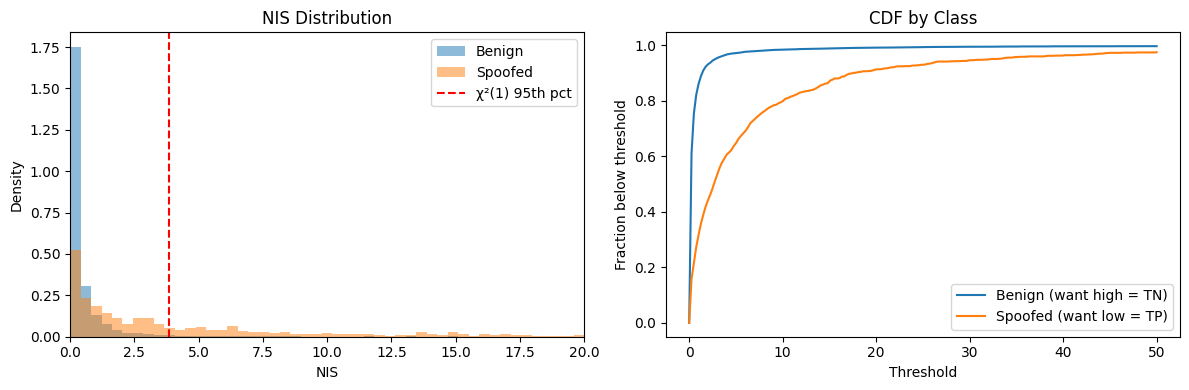

In [67]:
# Plot NIS distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Histogram
ax = axes[0]
bins = np.linspace(0, 20, 50)
ax.hist(nis_benign, bins=bins, alpha=0.5, label='Benign', density=True)
ax.hist(nis_spoofed, bins=bins, alpha=0.5, label='Spoofed', density=True)
ax.axvline(x=3.84, color='red', linestyle='--', label='χ²(1) 95th pct')
ax.set_xlabel('NIS')
ax.set_ylabel('Density')
ax.set_title('NIS Distribution')
ax.legend()
ax.set_xlim(0, 20)

# CDF (for ROC intuition)
ax = axes[1]
nis_range = np.linspace(0, 50, 200)
benign_cdf = [np.mean(nis_benign <= t) for t in nis_range]
spoofed_cdf = [np.mean(nis_spoofed <= t) for t in nis_range]
ax.plot(nis_range, benign_cdf, label='Benign (want high = TN)')
ax.plot(nis_range, spoofed_cdf, label='Spoofed (want low = TP)')
ax.set_xlabel('Threshold')
ax.set_ylabel('Fraction below threshold')
ax.set_title('CDF by Class')
ax.legend()

plt.tight_layout()
plt.show()

## Step 5: ROC Curve and Threshold Selection

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


AUC: 0.8280


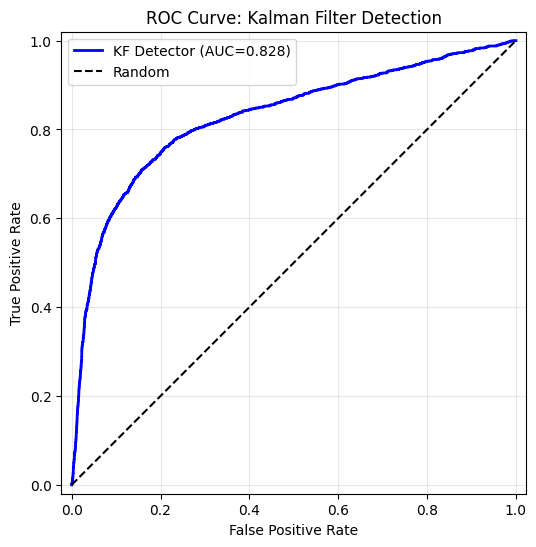

In [68]:
from evaluations.metrics import compute_roc_auc

# Use all non-NaN NIS values
valid = ~np.isnan(scenario.kf_nis)
y_true = scenario.is_spoofed[valid]
scores = scenario.kf_nis[valid]

auc, fpr, tpr, thresholds = compute_roc_auc(y_true, scores)

print(f"AUC: {auc:.4f}")

# Plot ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, 'b-', linewidth=2, label=f'KF Detector (AUC={auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Kalman Filter Detection')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.xlim(-0.02, 1.02)
plt.ylim(-0.02, 1.02)
plt.show()

In [69]:
# Find optimal threshold (maximize TPR - FPR)
j_statistic = tpr - fpr
best_idx = np.argmax(j_statistic)
best_threshold = thresholds[best_idx]

print(f"Optimal threshold: {best_threshold:.3f}")
print(f"At this threshold: TPR={tpr[best_idx]:.3f}, FPR={fpr[best_idx]:.3f}")

Optimal threshold: 0.870
At this threshold: TPR=0.710, FPR=0.158


## Summary

**The Kalman Filter detection approach:**

1. Each receiver maintains a KF per transmitter (identified by serial number)
2. For each RX event, compute TX power estimate: $z = RSSI + 10n\log_{10}(d_{claimed})$
3. Update KF and compute NIS
4. High NIS indicates claimed position inconsistent with RSSI → likely spoofing

**Strengths:**
- Works with a single receiver
- Tracks state over time (builds confidence)
- Principled statistical framework

**Weaknesses:**
- Requires good path loss model
- Sensitive to multipath/shadowing
- Spoofer could adapt TX power to match claimed distance